<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/c-torch-neural-network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural network with PyTorch

In the previous session we built our Model architecture from scratch without any deep learning framework. In this session we will build the same model but this time using Pytorch framework

Example based on https://jovian.ai/aakashns/mnist-logistic-minimal

In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28 # the size of the images
num_classes = 10 # the numbers 0-9

## Dataset & Data loaders

Loading the image dataset

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.




Label: 4


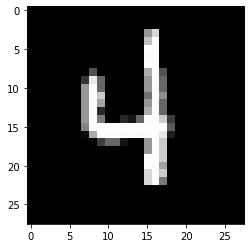

In [4]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model
Let's build the model architecture using Pytorch

In [5]:
class NeuralNetwork(nn.Module):
	def __init__(self):
		super().__init__()
#         [input_size, 32, 16, 10]        
		self.layer1 = nn.Linear(input_size, 32)
		self.layer2 = nn.Linear(32, 16)
		self.layer3 = nn.Linear(16, num_classes)        
		self.func_activation = nn.Sigmoid()

	def forward(self, xb):
		xb = xb.reshape(-1, 784) # flatting the matrix to [1,784]. -1 means find the right dimension.
		out = self.layer1(xb) # forward calculate gradients
		out = self.func_activation(out) # make the model no linear
		out = self.layer2(out) # forward calculate gradients
		out = self.func_activation(out) # make the model no linear        
		out = self.layer3(out) # forward calculate gradients        
		return out

	def training_batch(self, batch):
		images, labels = batch 
		out = self(images)                  # Generate predictions
		loss = F.cross_entropy(out, labels) # Calculate loss
		return loss
	
	def predict(self, img):
		xb = img.unsqueeze(0)
		yb = self(xb)
		return yb.detach().numpy()

	def train(self, epochs, lr, train_loader, val_loader, opt_func=torch.optim.SGD):
		history = []
		optimizer = opt_func(self.parameters(), lr)
		for epoch in range(epochs):
			# Training Phase 
			for batch in train_loader:
				loss = self.training_batch(batch)
				loss.backward()
				self.update_weights(optimizer)
				
			# Validation phase
			result = self.evaluate(val_loader)
			self.epoch_end(epoch, result)
			history.append(result)
		return history    

	def update_weights(self,optimizer):
		optimizer.step()
		optimizer.zero_grad()

	def accuracy(self, outputs, labels):
		_, preds = torch.max(outputs, dim=1)
		return torch.tensor(torch.sum(preds == labels).item() / len(preds))

	def evaluate(self, val_loader):
		outputs = [self.validation_batch(batch) for batch in val_loader]
		return self.validation_epoch_end(outputs)

	def validation_batch(self, batch):
		images, labels = batch 
		out = self(images)                    # Generate predictions
		loss = F.cross_entropy(out, labels)   # Calculate loss
		acc = self.accuracy(out, labels)           # Calculate accuracy
		return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
		batch_accs = [x['val_acc'] for x in outputs]
		epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
		return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

	def epoch_end(self, epoch, result):
		print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = NeuralNetwork()

## Training
Let's train our model

In [10]:
history = model.train(5, 0.1, train_loader, val_loader)

Epoch [0], val_loss: 1.9706, val_acc: 0.4630
Epoch [1], val_loss: 1.2119, val_acc: 0.6703
Epoch [2], val_loss: 0.8884, val_acc: 0.7630
Epoch [3], val_loss: 0.7030, val_acc: 0.8185
Epoch [4], val_loss: 0.5897, val_acc: 0.8484


Losses: 0.5896528959274292
Val accuracy: 0.848437488079071


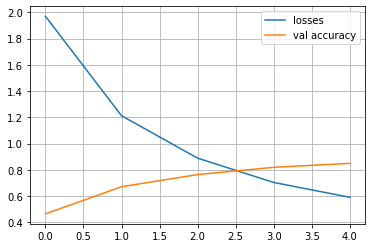

In [15]:
losses = [r['val_loss'] for r in history]
acc = [r['val_acc'] for r in history]
print("Losses:", losses[-1])
print("Val accuracy:", acc[-1])
plt.plot(losses, label='losses')
plt.plot(acc, label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

## Prediction
Let's evaluate our model ability to predict the number in the image

Label: 3 , Predicted: [3]


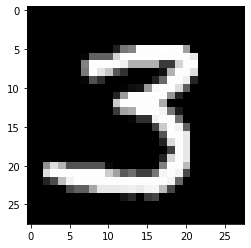

In [20]:
img, label = test_ds[912]
plt.imshow(img[0], cmap='gray')
predictions = model.predict(img)
prediction = predictions.argmax(axis=1)
print('Label:', label, ', Predicted:', predictions.argmax(axis=1))

## Save weights
We can save the weights of our model and use the model as any other program

In [9]:
# torch.save(model.state_dict(), 'mnist-logistic.pth')